[nltk_data] Downloading package punkt to /Users/jiaoyihan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiaoyihan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jiaoyihan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jiaoyihan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Random Forest Accuracy: 0.9814749470712774
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       515
           1       0.98      1.00      0.99      5153

    accuracy                           0.98      5668
   macro avg       0.97      0.92      0.94      5668
weighted avg       0.98      0.98      0.98      5668



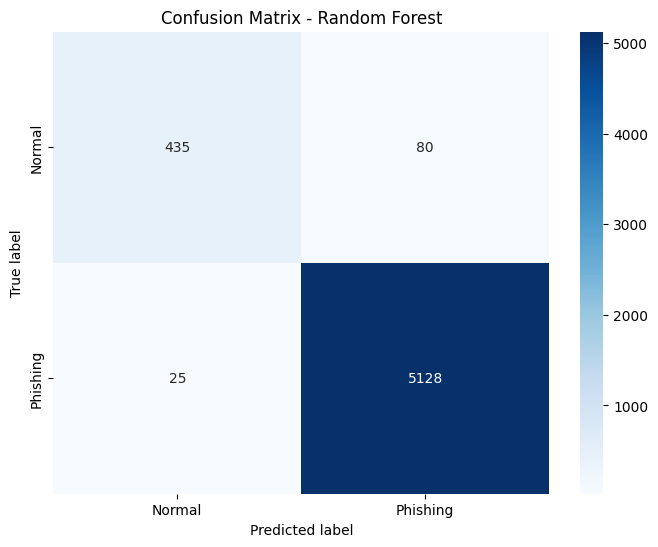

Random Forest AUC score: 0.983296938912011


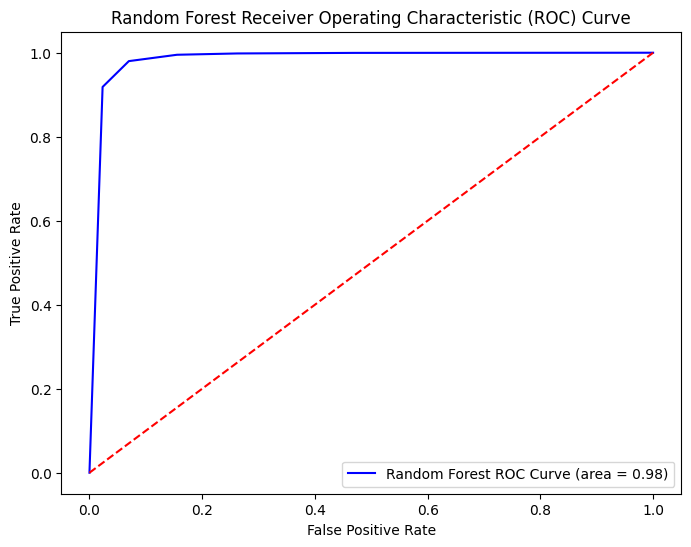

Random Forest model saved to: /Users/jiaoyihan/capstone/capstone_project/RandomForest_model.pkl


In [2]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# 文本预处理函数
def preprocess_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)  # 去掉邮箱地址
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # 去掉网址
    text = re.sub(r'\d+', '', text)  # 去掉数字
    text = re.sub(r'\W', ' ', text)  # 去掉标点符号
    text = re.sub(r'\s+', ' ', text)  # 去掉多余的空格
    return text

# 将文本转为词向量的函数
def text_to_word2vec(text, model, size):
    words = text.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(size)
    return np.mean(word_vecs, axis=0)

# 加载数据
data_path = '/Users/jiaoyihan/capstone/capstone_project/Combined_email.csv'
data = pd.read_csv(data_path)

# 确定文本和标签列名
text_columns = ['Subject', 'Body']
label_column = 'label'

# 将文本列转换为字符串并填充缺失值
for col in text_columns:
    data[col] = data[col].astype(str).fillna('')

# 文本预处理
data[text_columns[0]] = data[text_columns[0]].apply(preprocess_text)
data[text_columns[1]] = data[text_columns[1]].apply(preprocess_text)

# 合并文本列
data['text'] = data[text_columns[0]] + ' ' + data[text_columns[1]]

# 使用Word2Vec进行词向量化
texts = data['text'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=4)

data['word2vec'] = data['text'].apply(lambda x: text_to_word2vec(x, word2vec_model, 100))

# 将词向量展开成独立的列
word2vec_features = pd.DataFrame(data['word2vec'].tolist(), index=data.index)
data = pd.concat([data, word2vec_features], axis=1)

# 划分特征和标签
X = data.drop(columns=[label_column, 'text', 'word2vec', *text_columns])
y = data[label_column]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 初始化并训练随机森林模型，减少树的数量以降低复杂度
rf_model = RandomForestClassifier(n_estimators=5, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# 计算随机森林的准确率
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

# 打印随机森林的分类报告
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# 生成随机森林的混淆矩阵
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# 绘制随机森林的混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Phishing'], yticklabels=['Normal', 'Phishing'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# 计算随机森林的AUC得分
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"Random Forest AUC score: {roc_auc_rf}")

# 绘制随机森林的ROC曲线
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest ROC Curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 保存训练好的模型
rf_model_path = '/Users/jiaoyihan/capstone/capstone_project/RandomForest_model.pkl'
joblib.dump(rf_model, rf_model_path)
print(f"Random Forest model saved to: {rf_model_path}")


[nltk_data] Downloading package punkt to /Users/jiaoyihan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiaoyihan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jiaoyihan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jiaoyihan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Logistic Regression Accuracy: 0.9929453262786596
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        50
           1       0.99      1.00      1.00       517

    accuracy                           0.99       567
   macro avg       1.00      0.96      0.98       567
weighted avg       0.99      0.99      0.99       567



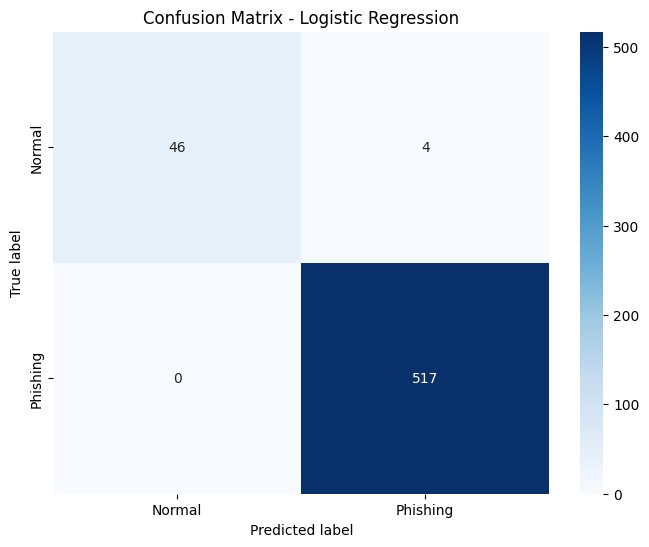

Logistic Regression AUC score: 0.9972147001934236


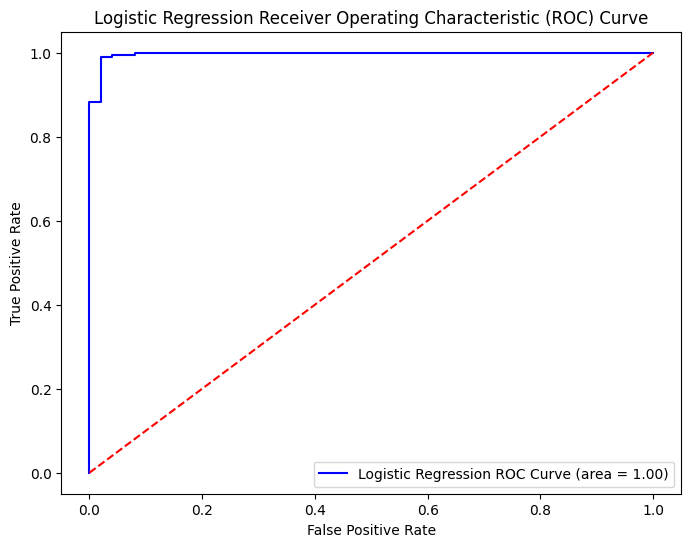

Logistic Regression model saved to: /Users/jiaoyihan/capstone/capstone_project/LogisticRegression_model.pkl


In [5]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# 文本预处理函数
def preprocess_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)  # 去掉邮箱地址
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # 去掉网址
    text = re.sub(r'\d+', '', text)  # 去掉数字
    text = re.sub(r'\W', ' ', text)  # 去掉标点符号
    text = re.sub(r'\s+', ' ', text)  # 去掉多余的空格
    return text

# 将文本转为词向量的函数
def text_to_word2vec(text, model, size):
    words = text.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(size)
    return np.mean(word_vecs, axis=0)

# 加载数据
data_path = '/Users/jiaoyihan/capstone/capstone_project/Combined_email.csv'
data = pd.read_csv(data_path)

# 确定文本和标签列名
text_columns = ['Subject', 'Body']
label_column = 'label'

# 将文本列转换为字符串并填充缺失值
for col in text_columns:
    data[col] = data[col].astype(str).fillna('')

# 文本预处理
data[text_columns[0]] = data[text_columns[0]].apply(preprocess_text)
data[text_columns[1]] = data[text_columns[1]].apply(preprocess_text)

# 合并文本列
data['text'] = data[text_columns[0]] + ' ' + data[text_columns[1]]

# 对数据进行采样，减少数据量
data_sampled = data.sample(frac=0.1, random_state=42)

# 使用Word2Vec进行词向量化
texts = data_sampled['text'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=4)

data_sampled['word2vec'] = data_sampled['text'].apply(lambda x: text_to_word2vec(x, word2vec_model, 100))

# 将词向量展开成独立的列
word2vec_features = pd.DataFrame(data_sampled['word2vec'].tolist(), index=data_sampled.index)
data_sampled = pd.concat([data_sampled, word2vec_features], axis=1)

# 划分特征和标签
X = data_sampled.drop(columns=[label_column, 'text', 'word2vec', *text_columns])
y = data_sampled[label_column]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 初始化并训练逻辑回归模型
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# 计算逻辑回归的准确率
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr}")

# 打印逻辑回归的分类报告
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# 生成逻辑回归的混淆矩阵
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# 绘制逻辑回归的混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Phishing'], yticklabels=['Normal', 'Phishing'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# 计算逻辑回归的AUC得分
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print(f"Logistic Regression AUC score: {roc_auc_lr}")

# 绘制逻辑回归的ROC曲线
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', label=f'Logistic Regression ROC Curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 保存训练好的模型
lr_model_path = '/Users/jiaoyihan/capstone/capstone_project/LogisticRegression_model.pkl'
joblib.dump(lr_model, lr_model_path)
print(f"Logistic Regression model saved to: {lr_model_path}")


[nltk_data] Downloading package punkt to /Users/jiaoyihan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiaoyihan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jiaoyihan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jiaoyihan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


SVM Accuracy: 0.995059985885674
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       255
           1       1.00      1.00      1.00      2579

    accuracy                           1.00      2834
   macro avg       0.99      0.98      0.98      2834
weighted avg       1.00      1.00      1.00      2834



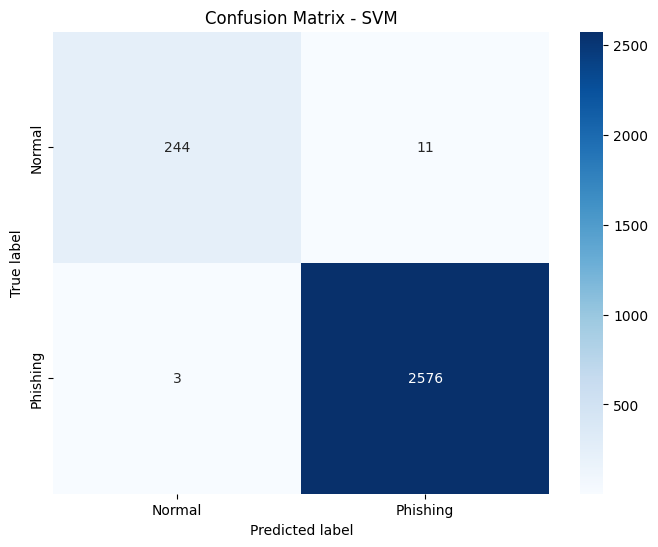

SVM AUC score: 0.999665473013556


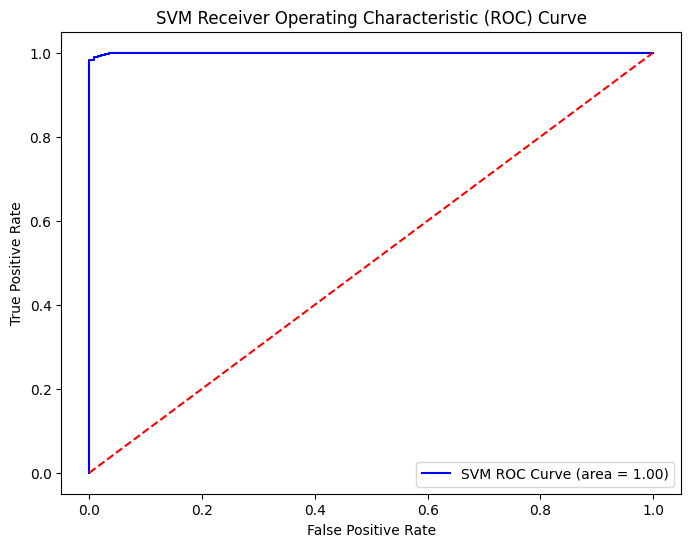

SVM model saved to: /Users/jiaoyihan/capstone/capstone_project/SVM_model.pkl


In [7]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# 文本预处理函数
def preprocess_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)  # 去掉邮箱地址
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # 去掉网址
    text = re.sub(r'\d+', '', text)  # 去掉数字
    text = re.sub(r'\W', ' ', text)  # 去掉标点符号
    text = re.sub(r'\s+', ' ', text)  # 去掉多余的空格
    return text

# 将文本转为词向量的函数
def text_to_word2vec(text, model, size):
    words = text.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(size)
    return np.mean(word_vecs, axis=0)

# 加载数据
data_path = '/Users/jiaoyihan/capstone/capstone_project/Combined_email.csv'
data = pd.read_csv(data_path)

# 确定文本和标签列名
text_columns = ['Subject', 'Body']
label_column = 'label'

# 将文本列转换为字符串并填充缺失值
for col in text_columns:
    data[col] = data[col].astype(str).fillna('')

# 文本预处理
data[text_columns[0]] = data[text_columns[0]].apply(preprocess_text)
data[text_columns[1]] = data[text_columns[1]].apply(preprocess_text)

# 合并文本列
data['text'] = data[text_columns[0]] + ' ' + data[text_columns[1]]

# 对数据进行采样，减少数据量，增加训练数量
data_sampled = data.sample(frac=0.5, random_state=42)

# 使用Word2Vec进行词向量化
texts = data_sampled['text'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=4)

data_sampled['word2vec'] = data_sampled['text'].apply(lambda x: text_to_word2vec(x, word2vec_model, 100))

# 将词向量展开成独立的列
word2vec_features = pd.DataFrame(data_sampled['word2vec'].tolist(), index=data_sampled.index)
data_sampled = pd.concat([data_sampled, word2vec_features], axis=1)

# 划分特征和标签
X = data_sampled.drop(columns=[label_column, 'text', 'word2vec', *text_columns])
y = data_sampled[label_column]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 初始化并训练SVM模型
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# 计算SVM的准确率
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm}")

# 打印SVM的分类报告
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# 生成SVM的混淆矩阵
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# 绘制SVM的混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Phishing'], yticklabels=['Normal', 'Phishing'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - SVM')
plt.show()

# 计算SVM的AUC得分
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
print(f"SVM AUC score: {roc_auc_svm}")

# 绘制SVM的ROC曲线
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', label=f'SVM ROC Curve (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 保存训练好的模型
svm_model_path = '/Users/jiaoyihan/capstone/capstone_project/SVM_model.pkl'
joblib.dump(svm_model, svm_model_path)
print(f"SVM model saved to: {svm_model_path}")


[nltk_data] Downloading package punkt to /Users/jiaoyihan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiaoyihan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jiaoyihan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jiaoyihan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


KNN Accuracy: 0.9887085391672548
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       255
           1       0.99      1.00      0.99      2579

    accuracy                           0.99      2834
   macro avg       0.97      0.96      0.96      2834
weighted avg       0.99      0.99      0.99      2834



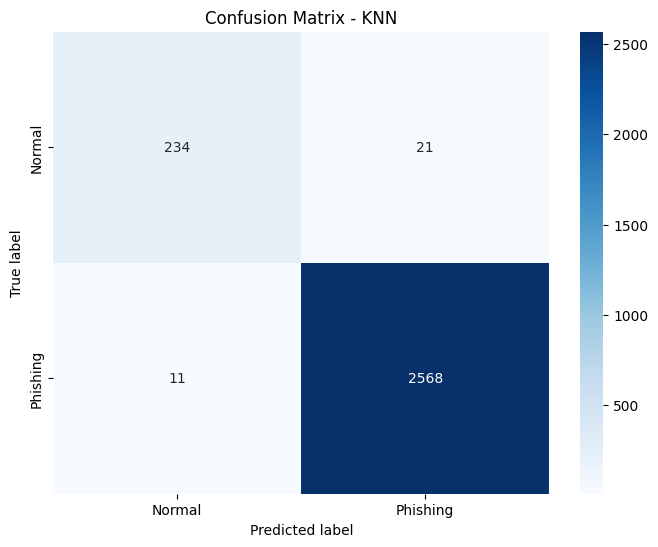

KNN AUC score: 0.9811904598985774


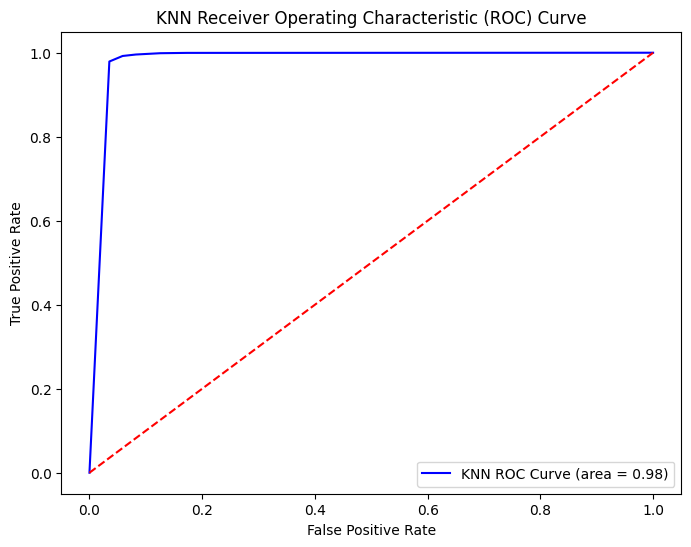

KNN model saved to: /Users/jiaoyihan/capstone/capstone_project/KNN_model.pkl


In [8]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# 文本预处理函数
def preprocess_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)  # 去掉邮箱地址
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # 去掉网址
    text = re.sub(r'\d+', '', text)  # 去掉数字
    text = re.sub(r'\W', ' ', text)  # 去掉标点符号
    text = re.sub(r'\s+', ' ', text)  # 去掉多余的空格
    return text

# 将文本转为词向量的函数
def text_to_word2vec(text, model, size):
    words = text.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(size)
    return np.mean(word_vecs, axis=0)

# 加载数据
data_path = '/Users/jiaoyihan/capstone/capstone_project/Combined_email.csv'
data = pd.read_csv(data_path)

# 确定文本和标签列名
text_columns = ['Subject', 'Body']
label_column = 'label'

# 将文本列转换为字符串并填充缺失值
for col in text_columns:
    data[col] = data[col].astype(str).fillna('')

# 文本预处理
data[text_columns[0]] = data[text_columns[0]].apply(preprocess_text)
data[text_columns[1]] = data[text_columns[1]].apply(preprocess_text)

# 合并文本列
data['text'] = data[text_columns[0]] + ' ' + data[text_columns[1]]

# 对数据进行采样，减少数据量，增加训练数量
data_sampled = data.sample(frac=0.5, random_state=42)

# 使用Word2Vec进行词向量化
texts = data_sampled['text'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=4)

data_sampled['word2vec'] = data_sampled['text'].apply(lambda x: text_to_word2vec(x, word2vec_model, 100))

# 将词向量展开成独立的列
word2vec_features = pd.DataFrame(data_sampled['word2vec'].tolist(), index=data_sampled.index)
data_sampled = pd.concat([data_sampled, word2vec_features], axis=1)

# 划分特征和标签
X = data_sampled.drop(columns=[label_column, 'text', 'word2vec', *text_columns])
y = data_sampled[label_column]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 初始化并训练KNN模型
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_knn = knn_model.predict(X_test)
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

# 计算KNN的准确率
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn}")

# 打印KNN的分类报告
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# 生成KNN的混淆矩阵
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# 绘制KNN的混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Phishing'], yticklabels=['Normal', 'Phishing'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - KNN')
plt.show()

# 计算KNN的AUC得分
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)
print(f"KNN AUC score: {roc_auc_knn}")

# 绘制KNN的ROC曲线
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', label=f'KNN ROC Curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 保存训练好的模型
knn_model_path = '/Users/jiaoyihan/capstone/capstone_project/KNN_model.pkl'
joblib.dump(knn_model, knn_model_path)
print(f"KNN model saved to: {knn_model_path}")
